In [8]:
from google.colab import drive

# Mount the drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import joblib
from sklearn.model_selection import KFold

In [22]:
def plot_learning_curve(estimator, title, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object
        An object of that type which is cloned for each validation.
        This object is assumed to implement the scikit-learn estimator interface.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features)
        Target relative to X for classification or regression;
        None for unsupervised learning.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Default is 5-fold cross-validation.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        None means 1 unless in a joblib.parallel_backend context.
        -1 means using all processors.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.

    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or a scorer callable object / function with
        signature scorer(estimator, X, y).
    """
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="red")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="blue")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="blue", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [23]:
df = pd.read_csv(r"/content/gdrive/MyDrive/audio_features_partial.csv")
df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,label,file_path
0,0.712224,0.055740,2989.050985,2193.800068,5666.294643,0.275144,-202.32579,27.614292,4.094784,5.301181,...,4.752774,-0.985637,-6.752584,-4.679379,-5.478848,-0.866508,-1.919669,-0.634521,Arabic,/kaggle/input/preprocess-common-language/proce...
1,0.598403,0.074004,2372.315827,2065.561020,4795.649510,0.178041,-137.41476,59.931843,5.077963,-5.712012,...,-12.469353,-2.134825,-10.989368,-1.460541,-4.485021,-0.408789,-8.211143,-5.170048,Arabic,/kaggle/input/preprocess-common-language/proce...
2,0.756316,0.046051,3274.178654,2196.474265,5870.572917,0.353054,-233.02031,22.691550,10.057923,3.829097,...,-1.657243,-5.409642,-4.017134,-6.744406,-1.697630,-0.387302,0.829549,1.292110,Arabic,/kaggle/input/preprocess-common-language/proce...
3,0.588983,0.061376,1948.418292,2049.242741,4186.921296,0.137682,-199.04490,80.806870,31.451380,-1.297673,...,-4.202263,0.065943,-9.312079,-7.164060,-3.082040,-8.046175,-3.083879,-2.018449,Arabic,/kaggle/input/preprocess-common-language/proce...
4,0.647222,0.069638,1705.618989,1824.714129,3730.709877,0.095540,-325.47556,92.373820,17.725632,31.867613,...,3.169903,4.538502,-1.073114,-1.204524,-0.108214,-4.803460,-2.882802,-1.455632,Arabic,/kaggle/input/preprocess-common-language/proce...


In [24]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder with your actual labels
label_encoder.fit(df['label'])

# Transform actual labels to numeric labels
df['numeric_labels'] = label_encoder.transform(df['label'])

In [25]:
X = df.drop(columns=['label','numeric_labels','file_path'])
y = df['numeric_labels']

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [13]:
from collections import Counter

# Jumlah kelas sebelum SMOTE
print("Jumlah kelas sebelum SMOTE:")
print(Counter(y))

# Jumlah kelas setelah SMOTE
print("\nJumlah kelas setelah SMOTE:")
print(Counter(y_resampled))

Jumlah kelas sebelum SMOTE:
Counter({2: 3570, 39: 3177, 19: 3012, 6: 3003, 27: 2955, 41: 2784, 24: 2766, 0: 2751, 20: 2733, 37: 2691, 10: 2550, 33: 2547, 18: 2520, 21: 2484, 42: 2472, 8: 2442, 40: 2367, 26: 2331, 30: 2283, 28: 2277, 23: 2268, 32: 2238, 7: 2202, 31: 2196, 43: 2181, 15: 2073, 44: 2073, 5: 2016, 34: 1977, 9: 1962, 25: 1947, 12: 1932, 1: 1914, 16: 1890, 29: 1884, 14: 1863, 3: 1830, 17: 1830, 4: 1797, 11: 1773, 35: 1758, 36: 1752, 38: 1737, 22: 1695, 13: 1623})

Jumlah kelas setelah SMOTE:
Counter({0: 3570, 4: 3570, 9: 3570, 27: 3570, 18: 3570, 24: 3570, 23: 3570, 13: 3570, 20: 3570, 11: 3570, 16: 3570, 40: 3570, 28: 3570, 15: 3570, 21: 3570, 8: 3570, 31: 3570, 29: 3570, 5: 3570, 7: 3570, 41: 3570, 44: 3570, 3: 3570, 2: 3570, 14: 3570, 43: 3570, 36: 3570, 26: 3570, 34: 3570, 12: 3570, 37: 3570, 35: 3570, 42: 3570, 33: 3570, 17: 3570, 25: 3570, 6: 3570, 30: 3570, 39: 3570, 22: 3570, 10: 3570, 1: 3570, 19: 3570, 32: 3570, 38: 3570})


In [14]:
### split data 80% 20%

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42,
                                                    stratify=y_resampled)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

np.random.seed(42)
# List untuk menyimpan skor
results = []

# Loop melalui nilai k dari 1 sampai 10
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Gunakan score() untuk menghitung akurasi
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)

    results.append({
        'k': k,
        'train_accuracy': train_score,
        'test_accuracy': test_score
    })

# Buat DataFrame untuk menampilkan hasil
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Temukan k terbaik berdasarkan test accuracy
best_k = df_results.loc[df_results['test_accuracy'].idxmax(), 'k']
print(f"\nNilai k terbaik (berdasarkan test accuracy): {best_k}")

 k  train_accuracy  test_accuracy
 1        1.000000       0.611267
 2        0.809555       0.479490
 3        0.740344       0.429816
 4        0.678066       0.394429
 5        0.628976       0.369904
 6        0.585831       0.346592
 7        0.552365       0.328634
 8        0.522603       0.315655
 9        0.497993       0.303890
10        0.477801       0.292312

Nilai k terbaik (berdasarkan test accuracy): 1


In [18]:
kmodel = KNeighborsClassifier(n_neighbors=1)

kmodel.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [19]:
kmodel.score(X_test,y_test)

0.6112667289137877

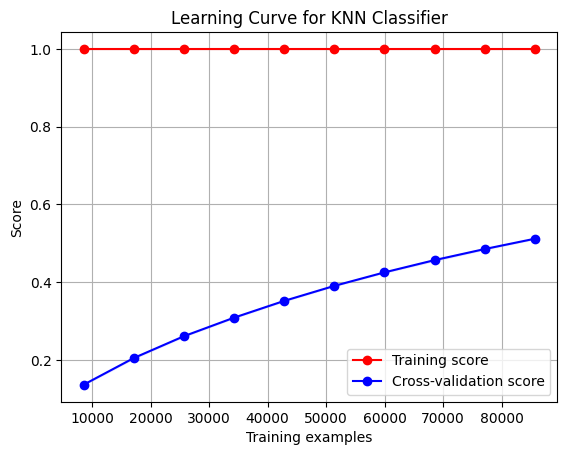

In [26]:
plot_learning_curve(kmodel, "Learning Curve for KNN Classifier", X_train, y_train)